In [3]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from os.path import join
import xarray as xr
import numpy as np
from mom6_helper import coarse_grain_h, coarse_grain_u, coarse_grain_v, tendencies_from_subgrid, zb2020

import sys
sys.path.append('../pyqg_test')
from util import cal_power_spectrum_2D, spectrum_regression, window

In [4]:
data_path = '/scratch/zl1574/mom6_simulation/double_gyre_R16_cartesian/output/'
#data_path = '/scratch/zanna/data/mom6/Feb2022/ZB2020/R4/FGR2/output/'
#data_path = '/scratch/zanna/data/mom6/Feb2022/ZB2020/R8/FGR2/output/'
ds_prog = xr.open_mfdataset(join(data_path, 'prog__????_???.nc'), combine="nested", concat_dim="Time")
#ds_mom = xr.open_mfdataset(join(data_path, 'mom__????_???.nc'), combine="nested", concat_dim="Time")

Shape = (243, 2, 321, 352)


<IPython.core.display.Javascript object>


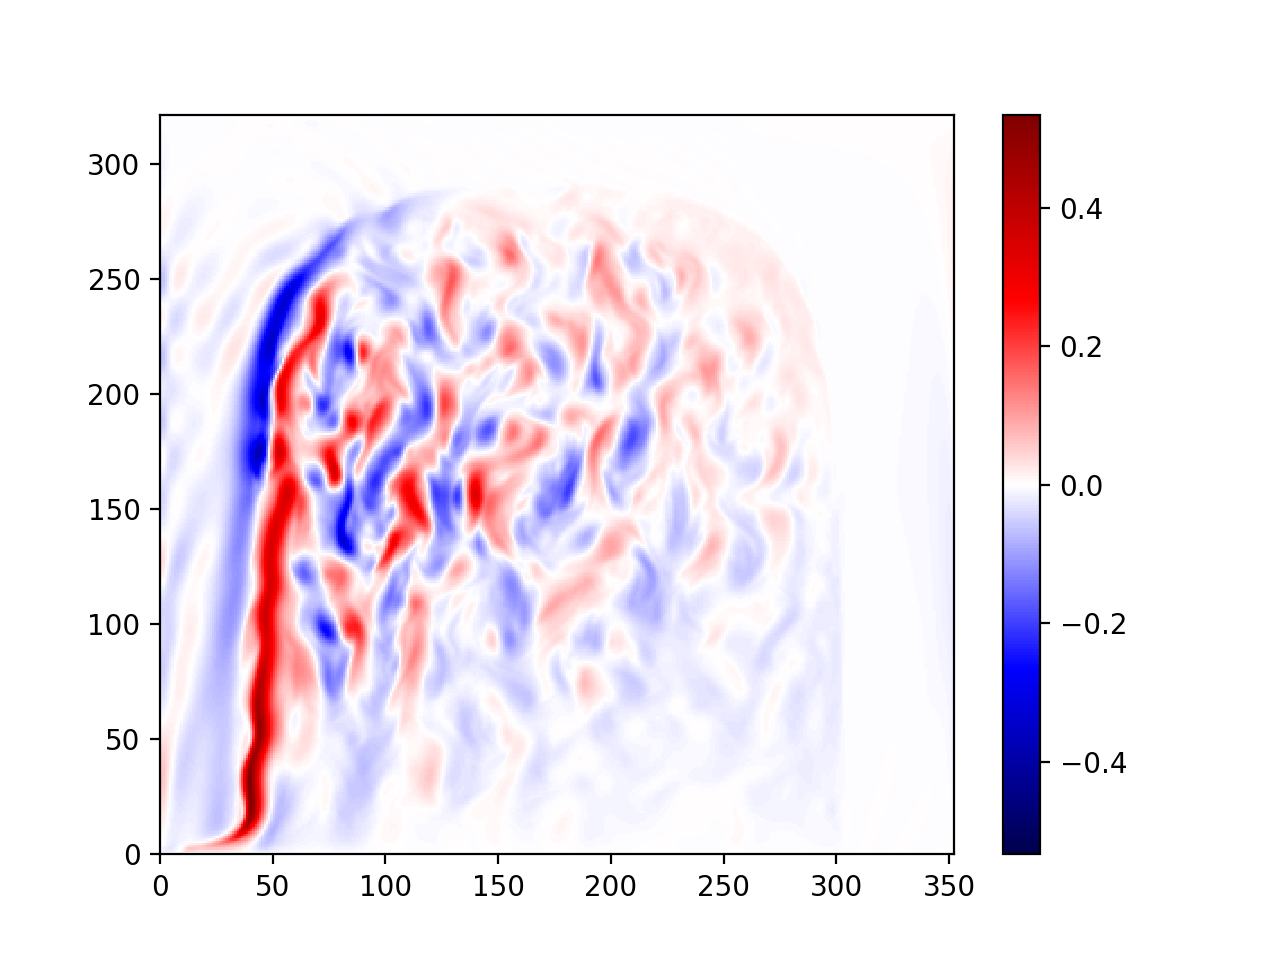

In [5]:
e_handle = ds_prog.v
print('Shape =',e_handle.shape)
plt.pcolormesh( e_handle[-1,0], cmap=matplotlib.cm.seismic); plt.colorbar()
plt.clim(np.array([-1, 1])*np.nanmax(np.abs(e_handle[-1,0].values)))

## Do coarse-grain on staggered C-grid
Largely follows Yani's paper at https://www.essoar.org/cms/asset/372a3ad6-974c-4bb0-8abb-fb04587b8fb8/si_momentum.pdf

In [6]:
n_scale = 4 # Must be multiples of 2
Nt, Nz, Ny, Nx = ds_prog.h.shape
Nx_c = int(Nx/n_scale)
Ny_c = int(Ny/n_scale)
u_c = np.zeros((Nt, Nz, Ny_c, Nx_c+1))
v_c = np.zeros((Nt, Nz, Ny_c+1, Nx_c))
u = np.array(ds_prog.u.data.squeeze())
v = np.array(ds_prog.v.data.squeeze())
u[:, :, :, 0] = 0; u[:, :, :, -1] = 0
v[:, :, 0, :] = 0; v[:, :, -1, :] = 0

In [7]:
u_c = coarse_grain_u(u, n_scale)
v_c = coarse_grain_v(v, n_scale)

t = 0
t = 100
t = 200
t = 0
t = 100
t = 200


<IPython.core.display.Javascript object>


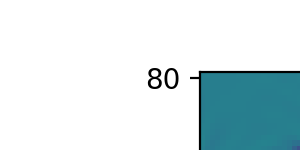

In [8]:
plt.figure(figsize = (8, 3))
plt.subplot(1, 2, 1)
plt.pcolormesh(v_c[-1, 0, :, :]); plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolormesh(v[-1, 0, :, :]); plt.colorbar()

In [9]:
## Get subgrid flux
# Interpolate to the center of the grid (h point in C-grid)
u_ch = (u_c[:, :, :, 0:-1] + u_c[:, :, :, 1:]) / 2
v_ch = (v_c[:, :, 0:-1, :] + v_c[:, :, 1:, :]) / 2
u_h = (u[:, :, :, 0:-1] + u[:, :, :, 1:]) / 2
v_h = (v[:, :, 0:-1, :] + v[:, :, 1:, :]) / 2
u2_h = (u[:, :, :, 0:-1]**2 + u[:, :, :, 1:]**2) / 2
v2_h = (v[:, :, 0:-1, :]**2 + v[:, :, 1:, :]**2) / 2

In [10]:
# Calculate coarse-grained fluxes
u_h_coarse  = coarse_grain_h(u_h, n_scale)
v_h_coarse  = coarse_grain_h(v_h, n_scale)
u2_h_coarse = coarse_grain_h(u2_h, n_scale)
v2_h_coarse = coarse_grain_h(v2_h, n_scale)
uv_h_coarse = coarse_grain_h(u_h*v_h, n_scale)

<IPython.core.display.Javascript object>


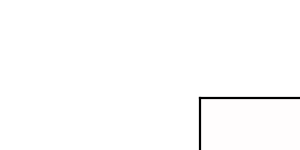

Text(0.5, 1.0, '$\\overline{u^2} - \\overline{u}^2$')

In [11]:
plt.figure(figsize = [8, 3])
plt.subplot(1, 2, 1)
temp1 = u2_h_coarse[-1, 0, :, :]
plt.imshow(temp1, vmin=-np.abs(temp1).max(), vmax=np.abs(temp1).max(), 
           origin = 'lower', cmap=plt.cm.seismic)
plt.colorbar()
plt.title(r'$\overline{u^2}$')

plt.subplot(1, 2, 2)
temp2 = u2_h_coarse[-1, 0, :, :] - u_ch[-1, 0, :, :]*u_ch[-1, 0, :, :]
plt.imshow(temp2, vmin=-np.abs(temp2).max(), vmax=np.abs(temp2).max(), 
           origin = 'lower', cmap=plt.cm.seismic)
plt.colorbar()
plt.title(r'$\overline{u^2} - \overline{u}^2$')


In [13]:
du_zb2020, dv_zb2020, uu_sub_zb2020, vv_sub_zb2020, uv_sub_zb2020 = zb2020(u_c, v_c)
du_az2017, dv_az2017, uu_sub_az2017, vv_sub_az2017, uv_sub_az2017 = zb2020(u_c, v_c, AZ2017 = True)

<IPython.core.display.Javascript object>


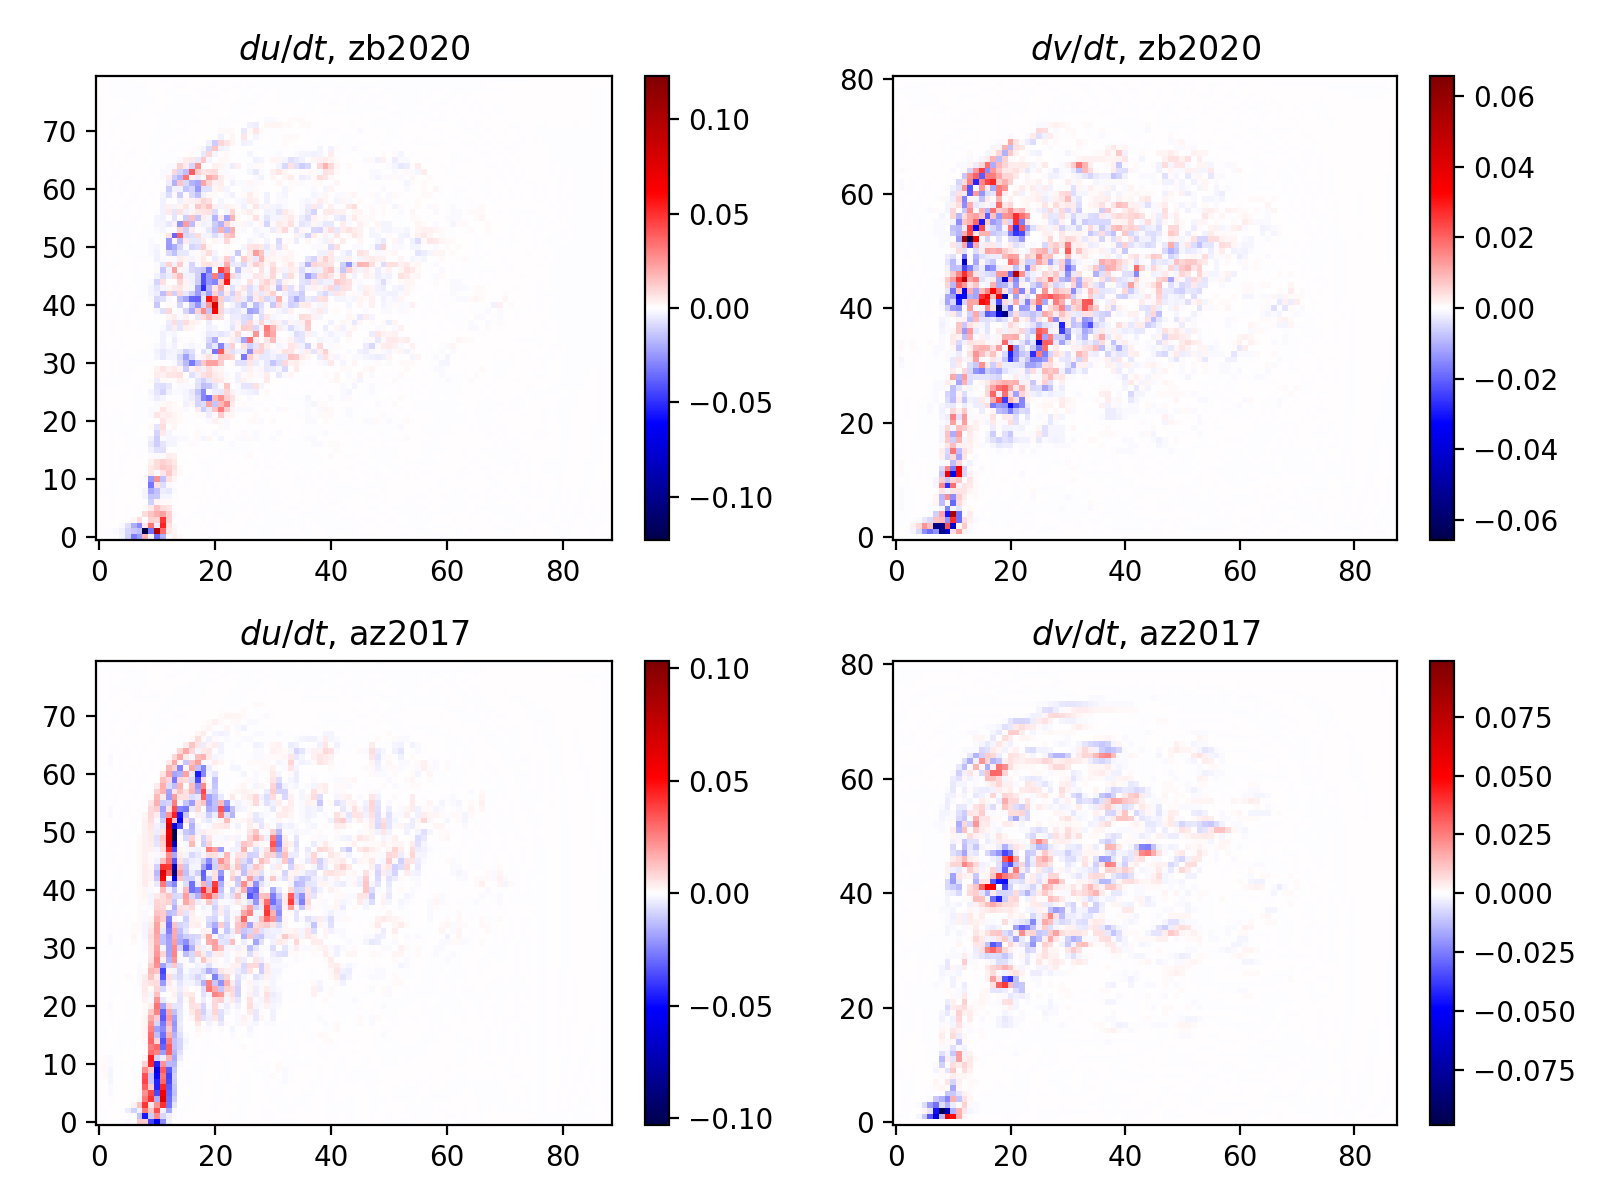

In [14]:
plt.figure(figsize = [8, 6])
t_plot = -1
plt.subplot(2, 2, 1)
temp1 = -du_zb2020[t_plot, 0, ...]
plt.imshow(temp1, vmin=-np.abs(temp1).max(), vmax=np.abs(temp1).max(), 
           cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()
plt.title(r'$du/dt$, zb2020')

plt.subplot(2, 2, 2)
temp2 = -dv_zb2020[t_plot, 0, ...]
plt.title(r'$dv/dt$, zb2020')
#temp2 = ds_mom.ZB2020u[t_plot, 0, :, :].values
#plt.title(r'$du/dt$, zb2020, model output')
plt.imshow(temp2, vmin=-np.nanmax(np.abs(temp2)), vmax=np.nanmax(np.abs(temp2)), 
           cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()

plt.subplot(2, 2, 3)
temp1 = -du_az2017[t_plot, 0, ...]
plt.imshow(temp1, vmin=-np.abs(temp1).max(), vmax=np.abs(temp1).max(), 
           cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()
plt.title(r'$du/dt$, az2017')
plt.subplot(2, 2, 4)
temp2 = -dv_az2017[t_plot, 0, ...]
plt.imshow(temp2, vmin=-np.abs(temp2).max(), vmax=np.abs(temp2).max(), 
           cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()
plt.title(r'$dv/dt$, az2017')

plt.tight_layout()

In [1]:
uu_sub_data = u_ch**2 - u2_h_coarse
uv_sub_data = u_ch*v_ch - uv_h_coarse
vv_sub_data = v_ch**2 - v2_h_coarse
du_data, dv_data = tendencies_from_subgrid(uu_sub_data, uv_sub_data, vv_sub_data)

NameError: name 'u_ch' is not defined

In [2]:
plt.figure(figsize = [6, 7])

plt.subplot(3, 2, 1)
temp1 = uv_sub_zb2020[-1, 0, :, :]
plt.imshow(temp1, vmin=-np.abs(temp1).max(), vmax=np.abs(temp1).max(), 
           cmap=plt.cm.seismic, origin = 'lower')
plt.colorbar()
plt.title(r'$\overline{uv} - \bar{u}\bar{v}$, zb2020')
plt.subplot(3, 2, 2)
temp2 = uv_sub_data[-1, 0, :, :]
plt.imshow(temp2, vmin=-np.abs(temp2).max(), vmax=np.abs(temp2).max(), 
           cmap=plt.cm.seismic, origin = 'lower')
plt.title(r'$\overline{uv} - \bar{u}\bar{v}$, data')
plt.colorbar()

plt.subplot(3, 2, 3)
temp1 = uu_sub_zb2020[-1, 0, :, :]
plt.imshow(temp1, vmin=-np.abs(temp1).max(), vmax=np.abs(temp1).max(), 
           cmap=plt.cm.seismic, origin = 'lower')
plt.colorbar()
plt.title(r'$\overline{u^2} - \bar{u}^2$, zb2020')
plt.subplot(3, 2, 4)
temp2 = uu_sub_data[-1, 0, :, :]
plt.imshow(temp2, vmin=-np.abs(temp2).max(), vmax=np.abs(temp2).max(), 
           cmap=plt.cm.seismic, origin = 'lower')
plt.title(r'$\overline{u^2} - \bar{u}^2$, data')
plt.colorbar()

plt.subplot(3, 2, 5)
temp1 = vv_sub_zb2020[-1, 0, :, :]
plt.imshow(temp1, vmin=-np.abs(temp1).max(), vmax=np.abs(temp1).max(), 
           cmap=plt.cm.seismic, origin = 'lower')
plt.colorbar()
plt.title(r'$\overline{v^2} - \bar{v}^2$, zb2020')
plt.subplot(3, 2, 6)
temp2 = vv_sub_data[-1, 0, :, :]
plt.imshow(temp2, vmin=-np.abs(temp2).max(), vmax=np.abs(temp2).max(), 
           cmap=plt.cm.seismic, origin = 'lower')
plt.title(r'$\overline{v^2} - \bar{v}^2$, data')
plt.colorbar()

plt.tight_layout()

NameError: name 'plt' is not defined

<IPython.core.display.Javascript object>


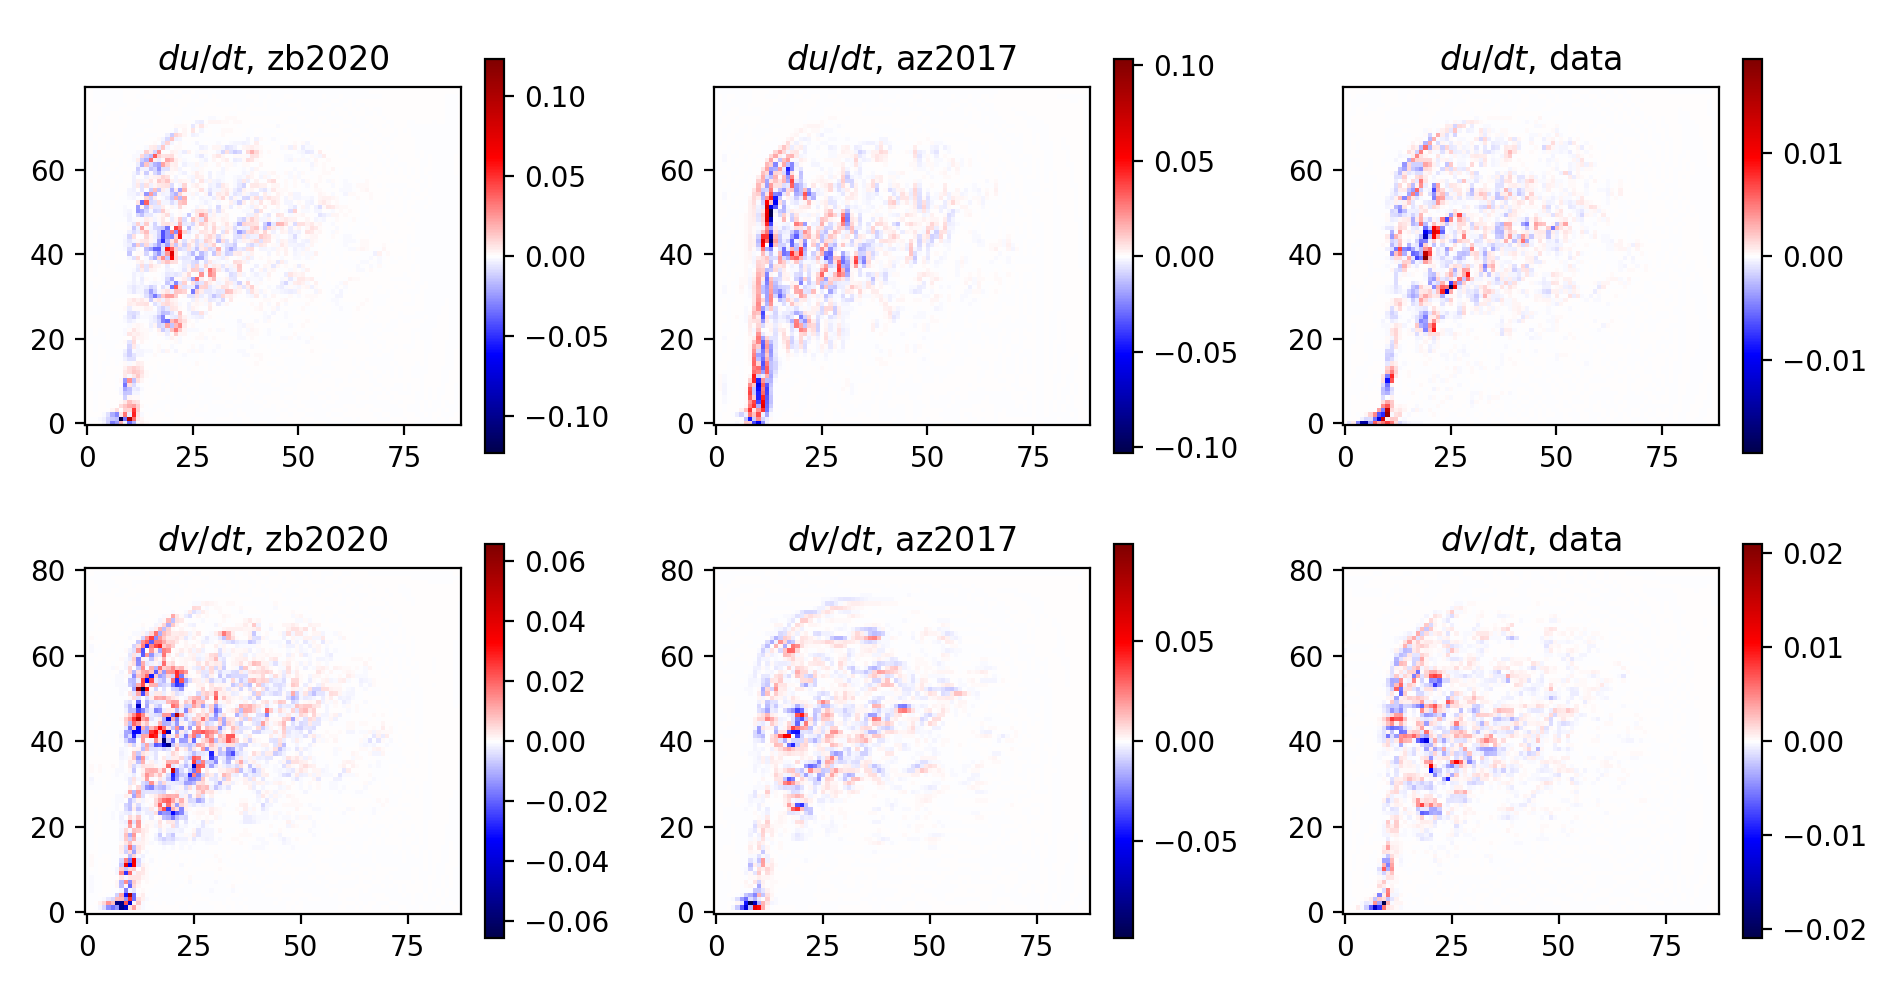

In [17]:
plt.figure(figsize = [9.5, 5])
t_plot = -1
plt.subplot(2, 3, 1)
temp1 = -du_zb2020[t_plot, 0, ...]
plt.title(r'$du/dt$, zb2020')
#temp1 = ds_mom.ZB2020u[t_plot, 0, :, :].values
#plt.title(r'$du/dt$, zb2020, model output')
plt.imshow(temp1, vmin=-np.abs(temp1).max(), vmax=np.abs(temp1).max(), 
           cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()

plt.subplot(2, 3, 2)
temp2 = -du_az2017[t_plot, 0, ...]
plt.title(r'$du/dt$, az2017')
plt.imshow(temp2, vmin=-np.nanmax(np.abs(temp2)), vmax=np.nanmax(np.abs(temp2)), 
           cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()

plt.subplot(2, 3, 3)
temp3 = -du_data[t_plot, 0, ...]
plt.title(r'$du/dt$, data')
plt.imshow(temp3, vmin=-np.nanmax(np.abs(temp3)), vmax=np.nanmax(np.abs(temp3)), 
           cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()

plt.subplot(2, 3, 4)
temp1 = -dv_zb2020[t_plot, 0, ...]
plt.imshow(temp1, vmin=-np.abs(temp1).max(), vmax=np.abs(temp1).max(), 
           cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()
plt.title(r'$dv/dt$, zb2020')

plt.subplot(2, 3, 5)
temp2 = -dv_az2017[t_plot, 0, ...]
plt.imshow(temp2, vmin=-np.abs(temp2).max(), vmax=np.abs(temp2).max(), 
           cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()
plt.title(r'$dv/dt$, az2017')

plt.subplot(2, 3, 6)
temp3 = -dv_data[t_plot, 0, ...]
plt.imshow(temp3, vmin=-np.abs(temp3).max(), vmax=np.abs(temp3).max(), 
           cmap=plt.cm.seismic, origin = 'lower'); plt.colorbar()
plt.title(r'$dv/dt$, data')

plt.tight_layout()

In [18]:
S_du_zb2020 = cal_power_spectrum_2D(du_zb2020[:, 0, int(Ny_c/4):-int(Ny_c/4), int(Nx_c/4):-int(Nx_c/4)], 
                                    WINDOW = True, DO_X = True, MEAN = True)
S_du_az2017 = cal_power_spectrum_2D(du_az2017[:, 0, int(Ny_c/4):-int(Ny_c/4), int(Nx_c/4):-int(Nx_c/4)], 
                                    WINDOW = True, DO_X = True, MEAN = True)
S_du_data = cal_power_spectrum_2D(du_data[:, 0, int(Ny_c/4):-int(Ny_c/4), int(Nx_c/4):-int(Nx_c/4)], 
                                  WINDOW = True, DO_X = True, MEAN = True)

In [19]:
dx = 0.25/180*np.pi*6371e3
_, bins_x_zb2020, S_x_zb2020 = spectrum_regression(S_du_zb2020, 0, 25, oneD = False, 
            N_bins = 25, dx = dx, dy = dx, bin_type = 'linear', regular_bin = True)
_, bins_x_az2017, S_x_az2017 = spectrum_regression(S_du_az2017, 0, 25, oneD = False, 
            N_bins = 25, dx = dx, dy = dx, bin_type = 'linear', regular_bin = True)
_, bins_x_data, S_x_data = spectrum_regression(S_du_data, 0, 25, oneD = False, 
            N_bins = 25, dx = dx, dy = dx, bin_type = 'linear', regular_bin = True)

<IPython.core.display.Javascript object>


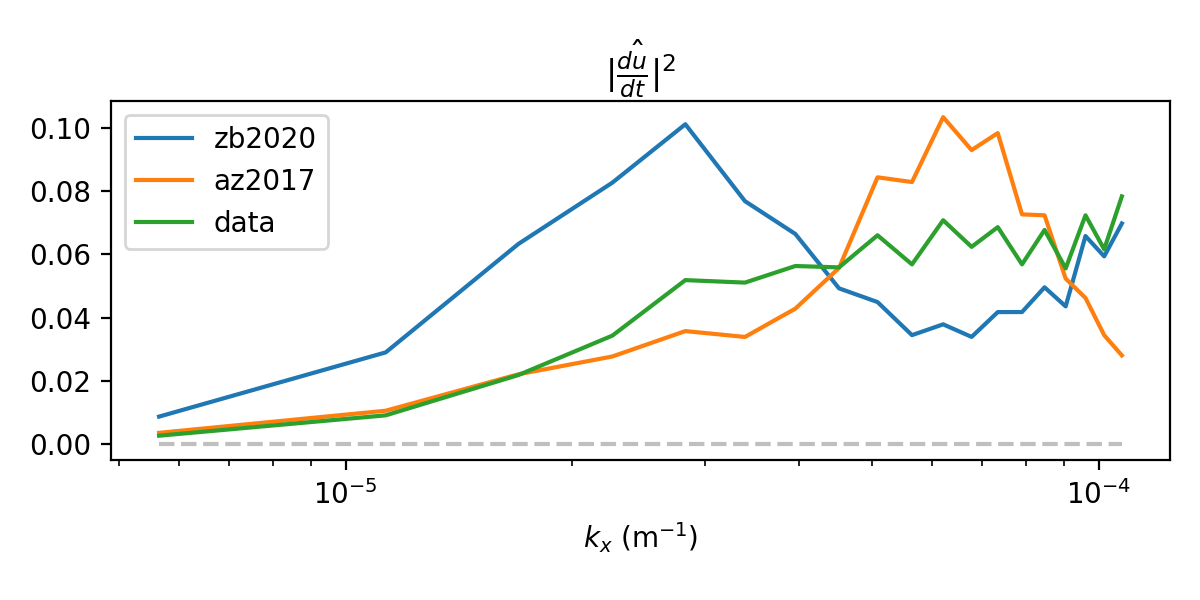

In [20]:
colors = ['tab:blue', 'tab:orange']
fig = plt.figure(figsize = [6, 3])
plt.plot(bins_x_zb2020, np.zeros(S_x_zb2020.shape), '--', color = 'grey', alpha = 0.5)
plt.plot(bins_x_zb2020, S_x_zb2020/S_x_zb2020.sum(), label = 'zb2020')
plt.plot(bins_x_az2017, S_x_az2017/S_x_az2017.sum(), label = 'az2017')
plt.plot(bins_x_data, S_x_data/S_x_data.sum(), label = 'data')
plt.xlabel(r'$k_x$ (m$^{-1}$)')
plt.xscale('log')
plt.title(r'$|\hat{\frac{du}{dt}}|^2$')
plt.legend(loc = 'best')
plt.tight_layout()